# Predicting the compressive strength of Concrete

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import neighbors, linear_model
from sklearn import preprocessing
from sklearn.cross_decomposition import PLSRegression
import statsmodels.formula.api as smf
import scipy
%matplotlib inline

In [2]:
# Load in data
data = pd.read_csv('Concrete_Data_Yeh.csv')
df = pd.DataFrame(data)

In [3]:
# inspect head of dataframe
display(df.head())

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Units are in $kg/m^3$ for all variables except age is in days and concrete compression strength is in MPa.

In [4]:
# check for null values
display(df.isnull().sum())

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

The goal is to predict the compressive strength of concrete, which is a measure of stress (or pressure).  Essentially, the compressive strength is a measure of how much pressure concrete can withstand.  I will be using two regression models to predict this outcome, OLS Regression and KNN Regression.  

The criteria for determining which model to go with will be the $R^2$ for the OLS model and mean accuracy for the KNN model.  I will also check the mean square error to further support the model strength.

# Ordinary Least Squares Model

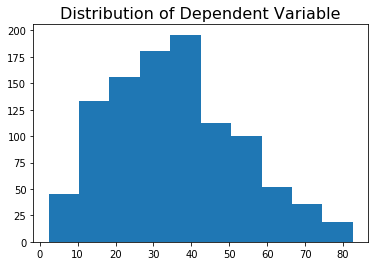

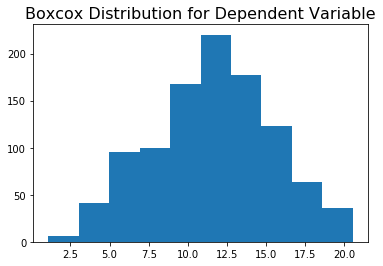

In [5]:
# First check the distribution of our dependent variable
features = df.drop('csMPa', axis=1)
depvar = df.csMPa
plt.hist(depvar)
plt.title('Distribution of Dependent Variable', fontsize=16)
plt.show()

# There is some slight right skewness to our dependent variable
plt.hist(scipy.stats.boxcox(depvar)[0])
plt.title('Boxcox Distribution for Dependent Variable', fontsize=16)
plt.show()

bcdepvar, lam = scipy.stats.boxcox(depvar)

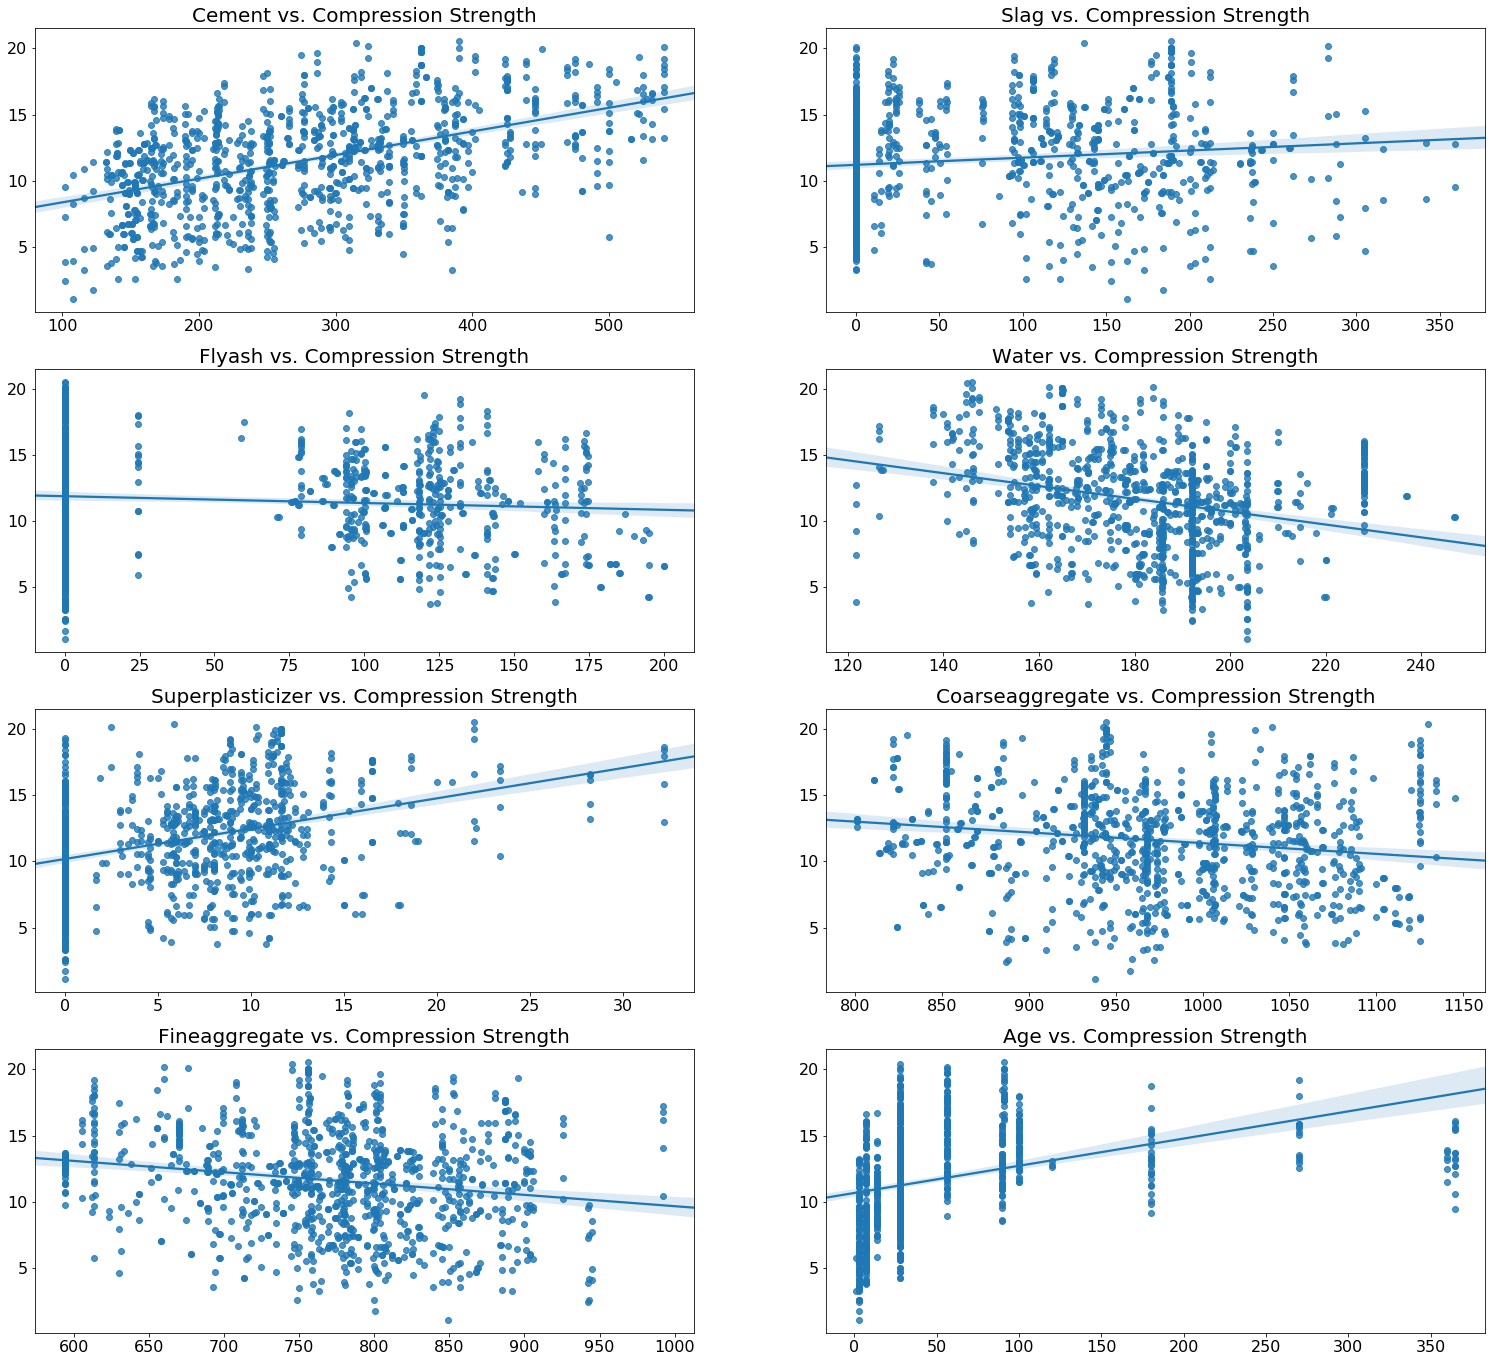

In [17]:
# check linearity of feature variables
fig = plt.figure(1, figsize=(26, 24))
numplt = 0
for col in features.columns:
    numplt += 1
    ax = fig.add_subplot(4, 2, numplt)
    sns.regplot(features[col], bcdepvar, ax=ax)
    ax.set_title(str(col).capitalize() + ' vs. Compression Strength', fontsize=20)
    ax.set_xlabel('')
    ax.tick_params(labelsize=16)
plt.show()


The worst relationship is from flyash.

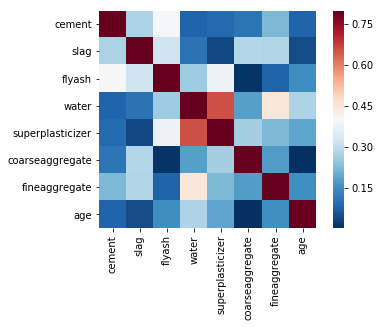

In [7]:
# check for correlation
corrmat = abs(features.corr())
sns.heatmap(corrmat, vmax=.8, square=True, cmap='RdBu_r')
plt.show()

Highest correlations between water and superplasticizer, water and fine aggregate, flyash and cement, flyash and superplasticizer.

In [22]:
# normalize the data - Max Min normalize
minmax = preprocessing.MinMaxScaler(feature_range=(0, 1))
nfeatures = pd.DataFrame(minmax.fit_transform(features), columns=features.columns)

# standardize the data - zscore
standard = preprocessing.StandardScaler()
sfeatures = pd.DataFrame(standard.fit_transform(features), columns=features.columns)

# we will go with the standardized data for the model because our data 
# has the same units for the most part but different scales

## Build the model

In [84]:
# Create linear regression function
def linregfunc(X, Y):
    # Split the data 80/20 to train and test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    # instantiate the model
    regr = linear_model.LinearRegression()
    
    # Fit the model
    regr.fit(X_train, Y_train)
    
    print('Coefficients')
    for varname, coef in zip(X_train.columns.tolist(), regr.coef_):
        print(str(varname)+':  '+ str(coef))
    print('\nIntercept: \n', regr.intercept_)
    print('\nR-squared:')
    print(regr.score(X_test, Y_test))
    
    # Extract predicted values.
    predicted = regr.predict(X_test)
    actual = Y_test
    
    # Calculate MSE
    mse = mean_squared_error(predicted, actual)
    print('\nMean Square Error: \n', mse)
    
    # Calculate the residual.
    residual = actual - predicted
    
    # Plot residuals to see the multivariate normality
    plt.hist(residual, edgecolor='k')
    plt.title('Residual counts')
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.show()
    
    # Plot the predicted values vs residuals to check homoscedasticity
    plt.scatter(predicted, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    plt.show()
    
    correlation_matrix = X_train.corr()
    display(correlation_matrix)

Coefficients
cement:  0.11899393308432299
slag:  0.10853559922579047
flyash:  0.08215181186302906
water:  -0.13527626344797666
superplasticizer:  0.3105699388301324
coarseaggregate:  0.01786715280587551
fineaggregate:  0.024099778717587485
age:  0.11643863566902107

Intercept: 
 -28.823554999692803

R-squared:
0.6275531792314852

Mean Square Error: 
 95.97094009110674


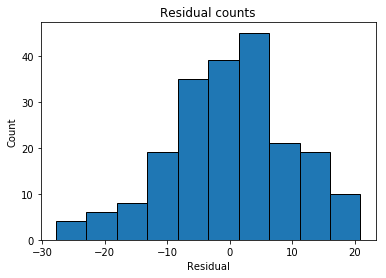

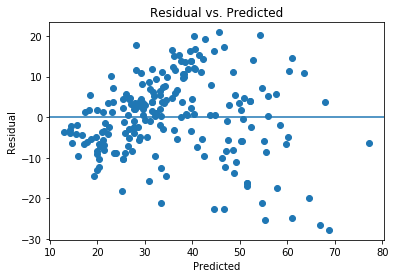

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
cement,1.000000,-0.292444,-0.408276,-0.079575,0.077144,-0.089068,-0.228866,0.097599
slag,-0.292444,1.000000,-0.315814,0.091486,0.055439,-0.287732,-0.251896,-0.051612
flyash,-0.408276,-0.315814,1.000000,-0.246652,0.365800,0.000601,0.069946,-0.156821
water,-0.079575,0.091486,-0.246652,1.000000,-0.653785,-0.169772,-0.434564,0.260538
superplasticizer,0.077144,0.055439,0.365800,-0.653785,1.000000,-0.263028,0.217674,-0.180280
coarseaggregate,-0.089068,-0.287732,0.000601,-0.169772,-0.263028,1.000000,-0.216624,-0.003823
fineaggregate,-0.228866,-0.251896,0.069946,-0.434564,0.217674,-0.216624,1.000000,-0.147267
age,0.097599,-0.051612,-0.156821,0.260538,-0.180280,-0.003823,-0.147267,1.000000


In [127]:
# run the model with out any adjustment
linregfunc(features, depvar)

The OLS model run on the unmodified data is not great.  While the $R^2 = 0.63$ is okay, the $MSE = 96.0$, indicated that our average guess for concrete compression strength is off by $9.80$ MPa.

Coefficients
cement:  0.026519365579237085
slag:  0.023675546132932233
flyash:  0.01934954815071213
water:  -0.028786000242821328
superplasticizer:  0.07003779683101888
coarseaggregate:  0.0035352382737636905
fineaggregate:  0.004491576403355568
age:  0.0269919763663252

Intercept: 
 -2.0106553315891276

R-squared:
0.6276501921633446

Mean Square Error: 
 5.174542977333458


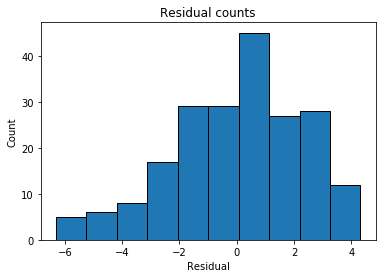

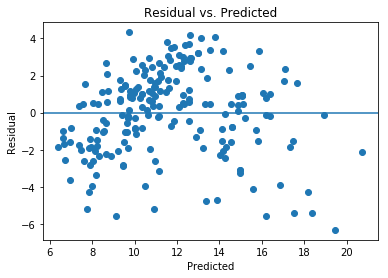

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
cement,1.000000,-0.292444,-0.408276,-0.079575,0.077144,-0.089068,-0.228866,0.097599
slag,-0.292444,1.000000,-0.315814,0.091486,0.055439,-0.287732,-0.251896,-0.051612
flyash,-0.408276,-0.315814,1.000000,-0.246652,0.365800,0.000601,0.069946,-0.156821
water,-0.079575,0.091486,-0.246652,1.000000,-0.653785,-0.169772,-0.434564,0.260538
superplasticizer,0.077144,0.055439,0.365800,-0.653785,1.000000,-0.263028,0.217674,-0.180280
coarseaggregate,-0.089068,-0.287732,0.000601,-0.169772,-0.263028,1.000000,-0.216624,-0.003823
fineaggregate,-0.228866,-0.251896,0.069946,-0.434564,0.217674,-0.216624,1.000000,-0.147267
age,0.097599,-0.051612,-0.156821,0.260538,-0.180280,-0.003823,-0.147267,1.000000


In [129]:
# model with unmodified features vs. boxcox transformed dependent variable
linregfunc(features, bcdepvar)

Transforming the dependent variable did not change the $R^2$ but it did significantly improve the $MSE$.

Coefficients
cement:  11.61548212370586
slag:  8.508991280175845
flyash:  3.871844584957495
water:  -3.6040072304012387
superplasticizer:  2.2552170579588005
coarseaggregate:  1.2161219661747178
fineaggregate:  1.7903423543775352
age:  9.825079397342378

Intercept: 
 2.71489934516166

R-squared:
0.6276501921633446

Mean Square Error: 
 5.1745429773334575


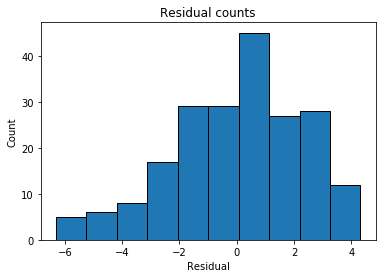

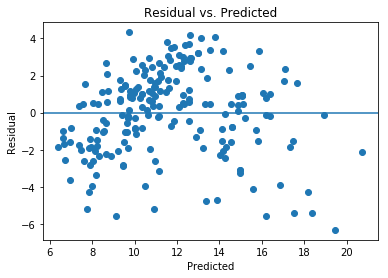

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
cement,1.000000,-0.292444,-0.408276,-0.079575,0.077144,-0.089068,-0.228866,0.097599
slag,-0.292444,1.000000,-0.315814,0.091486,0.055439,-0.287732,-0.251896,-0.051612
flyash,-0.408276,-0.315814,1.000000,-0.246652,0.365800,0.000601,0.069946,-0.156821
water,-0.079575,0.091486,-0.246652,1.000000,-0.653785,-0.169772,-0.434564,0.260538
superplasticizer,0.077144,0.055439,0.365800,-0.653785,1.000000,-0.263028,0.217674,-0.180280
coarseaggregate,-0.089068,-0.287732,0.000601,-0.169772,-0.263028,1.000000,-0.216624,-0.003823
fineaggregate,-0.228866,-0.251896,0.069946,-0.434564,0.217674,-0.216624,1.000000,-0.147267
age,0.097599,-0.051612,-0.156821,0.260538,-0.180280,-0.003823,-0.147267,1.000000


In [87]:
# model with normalized data and boxcox dependent variable
linregfunc(nfeatures, bcdepvar)

Coefficients
cement:  2.770096798262802
slag:  2.0417186880218257
flyash:  1.237711844508713
water:  -0.6144040690444458
superplasticizer:  0.41819153620821836
coarseaggregate:  0.2747452853080818
fineaggregate:  0.3599416842177471
age:  1.7042528503532106

Intercept: 
 11.59835445587432

R-squared:
0.6276501921633445

Mean Square Error: 
 5.174542977333459


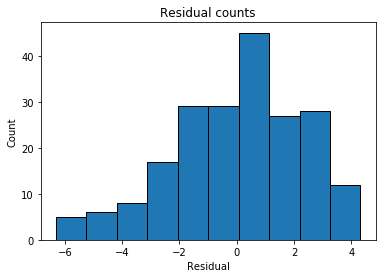

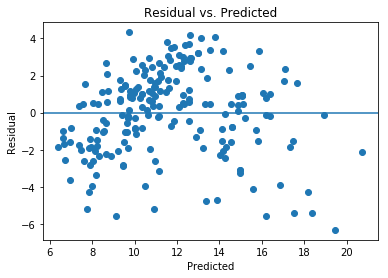

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
cement,1.000000,-0.292444,-0.408276,-0.079575,0.077144,-0.089068,-0.228866,0.097599
slag,-0.292444,1.000000,-0.315814,0.091486,0.055439,-0.287732,-0.251896,-0.051612
flyash,-0.408276,-0.315814,1.000000,-0.246652,0.365800,0.000601,0.069946,-0.156821
water,-0.079575,0.091486,-0.246652,1.000000,-0.653785,-0.169772,-0.434564,0.260538
superplasticizer,0.077144,0.055439,0.365800,-0.653785,1.000000,-0.263028,0.217674,-0.180280
coarseaggregate,-0.089068,-0.287732,0.000601,-0.169772,-0.263028,1.000000,-0.216624,-0.003823
fineaggregate,-0.228866,-0.251896,0.069946,-0.434564,0.217674,-0.216624,1.000000,-0.147267
age,0.097599,-0.051612,-0.156821,0.260538,-0.180280,-0.003823,-0.147267,1.000000


In [85]:
# model with standardized data and boxcox dependent variable
linregfunc(sfeatures, bcdepvar)

After running the OLS Regression on the standardized dataset and the normalized dataset, we still have an $R^2 = 0.63$ and $MSE = 5.17$. The is an okay $R^2$ but we'll try to improve this by creating some additional features and finding more linear relationships.  Our improved $MSE = 5.17$ tells us that our average guess of concrete compression strength is off by $2.27$ MPa.  

We still have the correlation but since we are making a prediction model this is not as big of an issue.

In [67]:
# combine data into one dataset
combo = sfeatures.copy()
combo['bcdepvar'] = bcdepvar

linform = 'bcdepvar ~ cement + slag + flyash + water + superplasticizer + coarseaggregate + fineaggregate + age'
lm = smf.ols(formula=linform, data=combo).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               bcdepvar   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     196.7
Date:                Thu, 18 Oct 2018   Prob (F-statistic):          8.07e-201
Time:                        15:35:33   Log-Likelihood:                -2356.7
No. Observations:                1030   AIC:                             4731.
Df Residuals:                    1021   BIC:                             4776.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.6014      0.075  

We can see that the model performs well in terms of F-Score, but the two aggregate variables aren't contributing much.  Let's drop them and play around with creating better linear relationships between the variables and compression strength.

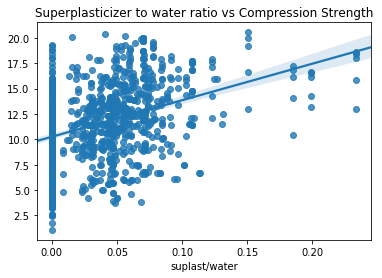

In [134]:
# Create new feature dataset
# We choose the original data to be able to add binary variables
features1 = features.copy()
features1 = features1.drop(['coarseaggregate', 'fineaggregate'], axis=1)

# The highest correlation is between water and superplasticizer
# Google tells me that a superplasticizer is need when the amount of water is low to improve workability.
# The strength of concrete is inversely proportional to the amount of water added
features1['suplast/water'] = features1.superplasticizer/features1.water
features1['water'] = 1/features1.water

# Flyash has a lot of 0 values so lets turn them into a binary
features1['flyash'] = np.where(features1.flyash == 0, 0, 1)

# Let's add an age squared feature 
features1['age_squared'] = df.age**2

sns.regplot(features1['suplast/water'], bcdepvar)
plt.title('Superplasticizer to water ratio vs Compression Strength')
plt.show()

## Rebuild the model

Coefficients
cement:  0.023927631668336564
slag:  0.019299602832072982
flyash:  1.5406394168262438
water:  1975.3411729611673
superplasticizer:  0.6841658361747437
age:  0.08377515194801297
suplast/water:  -106.14606600612451
age_squared:  -0.00019515842626598168

Intercept: 
 -11.225277673321495

R-squared:
0.7663927422974591

Mean Square Error: 
 3.2464386159401464


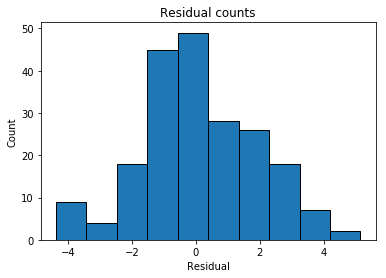

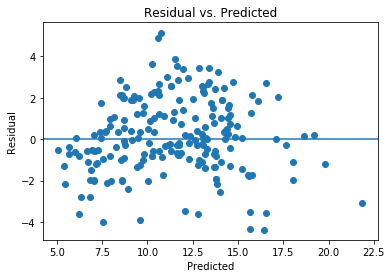

,cement,slag,flyash,water,superplasticizer,age,suplast/water,age_squared
cement,1.000000,-0.292444,-0.365827,0.103288,0.077144,0.097599,0.116660,0.105426
slag,-0.292444,1.000000,-0.326388,-0.089235,0.055439,-0.051612,0.043321,-0.054698
flyash,-0.365827,-0.326388,1.000000,0.236040,0.383543,-0.163852,0.319182,-0.176439
water,0.103288,-0.089235,0.236040,1.000000,0.672385,-0.219757,0.729872,-0.230540
superplasticizer,0.077144,0.055439,0.383543,0.672385,1.000000,-0.180280,0.988706,-0.203519
age,0.097599,-0.051612,-0.163852,-0.219757,-0.180280,1.000000,-0.162947,0.924912
suplast/water,0.116660,0.043321,0.319182,0.729872,0.988706,-0.162947,1.000000,-0.185518
age_squared,0.105426,-0.054698,-0.176439,-0.230540,-0.203519,0.924912,-0.185518,1.000000


In [136]:
# run model on new features vs boxcox dependent variable
linregfunc(features1, bcdepvar)

In [118]:
# combine data into one dataset
combo1 = features1.copy()
combo1['bcdepvar'] = bcdepvar

linform1 = "bcdepvar ~ cement + slag + flyash + water + superplasticizer + age + Q('suplast/water') + Q('age_squared')"
lm = smf.ols(formula=linform1, data=combo1).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               bcdepvar   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     397.9
Date:                Thu, 18 Oct 2018   Prob (F-statistic):          1.57e-307
Time:                        16:36:15   Log-Likelihood:                -2108.2
No. Observations:                1030   AIC:                             4234.
Df Residuals:                    1021   BIC:                             4279.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -11.6139      0

So by creating 4 new features we have improved the $R^2$ to $R^2 = 0.77$ and improved the MSE to $MSE = 3.25$.  We can see that our residuals are normally distributed and that they are bound by $[-4, 4]$ given us a fairly homoscedastic error.  The model is including only significant variables as is seen in the summary from the OLS performed by the stats.model package.  The F-Stat is also significant.  

We can see that in the regression func we are scoring the model on the testing set created; whereas, in the stats.model package we are including the full dataset.  These two $R^2$ values are similar which tells us our model is validating well.  Let's see if we can apply some Partial Least Squares Regression to reduce the number of components in the model.

In [157]:
def PLSR(n, x, y):

    regr1 = linear_model.LinearRegression()
    regr1.fit(x, y)
    print('R-squared regression:', regr1.score(x, y))
   
    pls = PLSRegression(n_components=n)

    # Reduce X to R(X) and regress on y.
    pls.fit(x, y)

    # Save predicted values.
    Y_pred = regr1.predict(x)
    Y_PLS_pred = pls.predict(x)
    print('R-squared PLSR: ', pls.score(x, y))


In [166]:
for i,j in enumerate(range(1, features1.shape[1]+1), 1):
    print('Number of components: '+ str(i))
    PLSR(j, features1, bcdepvar)
    print('')

Number of components: 1
R-squared regression: 0.7571600853421284
R-squared PLSR:  0.4326884842833546

Number of components: 2
R-squared regression: 0.7571600853421284
R-squared PLSR:  0.499123994266347

Number of components: 3
R-squared regression: 0.7571600853421284
R-squared PLSR:  0.6179095122757343

Number of components: 4
R-squared regression: 0.7571600853421284
R-squared PLSR:  0.6812223797844421

Number of components: 5
R-squared regression: 0.7571600853421284
R-squared PLSR:  0.725399867349543

Number of components: 6
R-squared regression: 0.7571600853421284
R-squared PLSR:  0.7457776127744891

Number of components: 7
R-squared regression: 0.7571600853421284
R-squared PLSR:  0.7485947340534564

Number of components: 8
R-squared regression: 0.7571600853421284
R-squared PLSR:  0.7571600853421283



With PLSR we can probably get away with reducing the number of variables in the model to 5.  Lastly, let's cross validate the model to see how well it validates.

## Cross Validate Final Linear Regression Model

In [210]:
# instantiate model for cross validation
lr = linear_model.LinearRegression()

# get the R2 for error calculation
lr.fit(features1, bcdepvar)
actual = lr.score(features1, bcdepvar)

score = cross_val_score(lr, features1, bcdepvar, cv=5)
print(score)
cv_error = np.abs(score.mean() - actual)/actual * 100
print('Error: {:0.2f}%'.format(cv_error))
print('Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

# we get a wacky score for the cross-validation when cv=10

[0.60811009 0.66820487 0.68800595 0.74588614 0.59875339]
Error: 12.60%
Accuracy: 0.66 (+/- 0.11)


It appears that our model has an accuracy of .66 (+/- 0.11) and a testing error of 12.6%.

# KNN Regression

Now we will try modeling the same data with a KNN Regression.  For KNN regression we will need to use either the normalized or standardized data because the variables have to all be on the same scale.

In [223]:
def weighted(x, y, k=10, cv=5):
    #instantiate the model and fit the data
    knnw = neighbors.KNeighborsRegressor(n_neighbors=k, weights='distance')
    knnw.fit(x, y)
    
    # predict the outcome
    Y_ = knnw.predict(x)
    
    # get the scores for 1 to k neighbors
    cv_scores = []
    for i in range(1,k+1):
        knn = neighbors.KNeighborsRegressor(n_neighbors=i, weights='distance')
        scores = cross_val_score(knn, x, y, cv=cv)
        cv_scores.append(scores.mean())
    # plot the average accuracy vs K value    
    plt.plot(range(1,k+1), cv_scores, color='r', ls='dashed', marker='o', mfc='b', ms=10)
    plt.title('Accuracy vs K value')
    plt.xlabel('K value')
    plt.ylabel('Accuracy')
    plt.show()
    
    # show the accuracy for the model with k=k neighbors and 95% CI
    score_w = cross_val_score(knnw, x, y, cv=cv)
    print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))
    
    # calculate the MSE
    #mse = ((Y_ - y)**2).sum()/len(Y_)
    mse = mean_squared_error(Y_, y)
    print('Mean squared error: ', mse)

# normalize the data - Max Min normalize
ndf = pd.DataFrame(minmax.fit_transform(df), columns=df.columns)

# standardize the data - zscore
sdf = pd.DataFrame(standard.fit_transform(df), columns=df.columns)

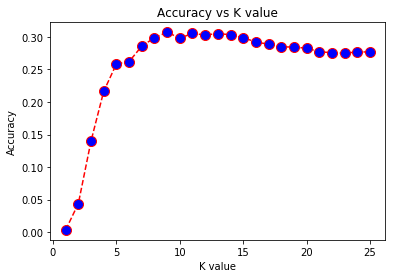

Weighted Accuracy: 0.28 (+/- 0.30)
Mean squared error:  1.1003200323624596


In [224]:
# KNN without standardizing
weighted(df.drop('csMPa', axis=1), df.csMPa, 25)

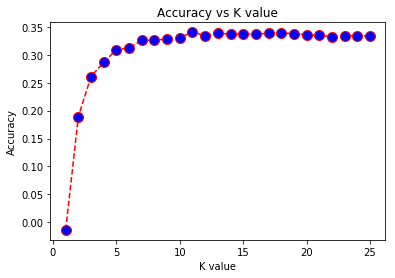

Weighted Accuracy: 0.33 (+/- 0.24)
Mean squared error:  0.00017077035994586843


In [225]:
# KNN model with normalized data
weighted(ndf.drop('csMPa', axis=1), ndf.csMPa, 25)

With the normalized data we can see that our optimal K-values is 11.

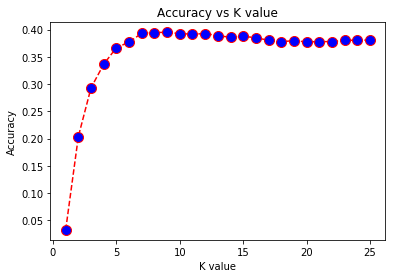

Weighted Accuracy: 0.38 (+/- 0.23)
Mean squared error:  0.003946474779751382


In [226]:
# KNN model with standardized data
weighted(sdf.drop('csMPa', axis=1), sdf.csMPa, 25)

Standardized data gives an optimal K-value of 7.

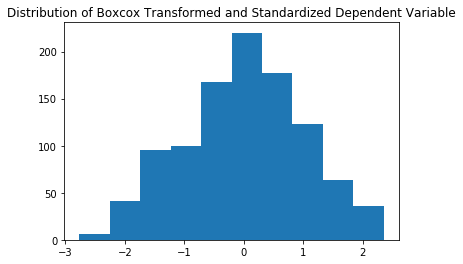

In [227]:
# let's re apply the boxcox transform to our data
sdf1 = sdf.copy()
sdf1['csMPa'] = scipy.stats.boxcox(df.csMPa)[0]
sdf1['csMPa'] = scipy.stats.zscore(sdf1.csMPa)

plt.hist(sdf1.csMPa)
plt.title('Distribution of Boxcox Transformed and Standardized Dependent Variable')
plt.show()


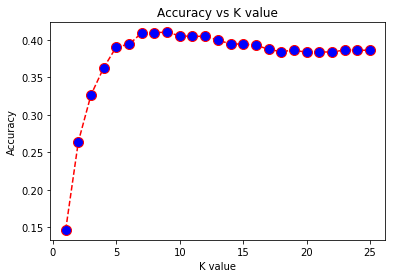

Weighted Accuracy: 0.39 (+/- 0.21)
Mean squared error:  0.0035200280499112467


In [228]:
# KNN model with standardized data and boxcox transformed dependent variable
weighted(sdf1.drop('csMPa', axis=1), sdf1.csMPa, 25)

We have slightly improved the model and the optimal k-value is 7 or 9.

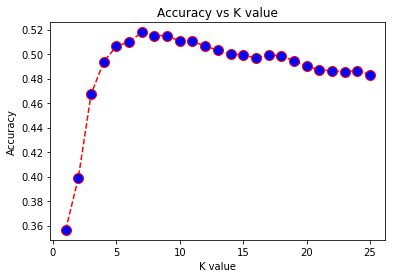

Weighted Accuracy: 0.48 (+/- 0.22)
Mean squared error:  0.004918201112054267


In [229]:
# we know from earlier exploration that the two aggregate variables were not significant in the linear model 
# Lets see what happens if we drop them
weighted(sdf1.drop(['csMPa', 'fineaggregate', 'coarseaggregate'], axis=1), sdf1.csMPa, 25)

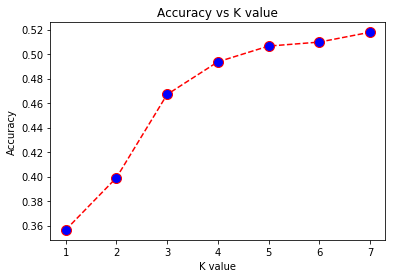

Weighted Accuracy: 0.52 (+/- 0.26)
Mean squared error:  0.004918201112054267


In [230]:
weighted(sdf1.drop(['csMPa', 'fineaggregate', 'coarseaggregate'], axis=1), sdf1.csMPa, 7)

# Conclusion

After creating two models to predict the compression strength of concrete I will have to choose the Ordinary Least Squares model as the winner.  While the KNN model is very simple to implement the accuracy for the OLS model was better than the KNN model.  And the final $R^2$ and MSE for the OLS was good.  Interesting to note that the MSE for the KNN model was vastly better than anything I was able to get from the OLS (maybe this needs to be looked at).  

A situation that would have changed my mind on selecting the OLS model would have been if I was able to at least match the accuracy with the KNN model.  Perhaps, applying PCA to the data prior to running the KNN model would help make the distance metric more meaningful.

Lastly, I believe the data favored the OLS model because of the linear relationships within the data.